In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.5 MB/s eta 0:00:00


In [ ]:
import os
import re
import string
from typing import List, Tuple, Callable
from openai import OpenAI

In [ ]:
os.environ["PINECONE_API_KEY"] = "8fbda215-004c-43c0-89c8-fd624a1dbe53"
os.environ["OPENAI_API_KEY"] = "sk-proj-qgqW1hq0xTLkUXPyOebXT3BlbkFJLJgoDe1gHbLGGF8tiGZd"

In [ ]:
class DataSource:
    def __init__(self, data: List[str]):
        self.data = data

    def preprocess_text(self, text: str) -> str:
      """
      Preprocesses the text by lowercasing, removing punctuation, and removing extra whitespace.

      Args:
          text (str): The input text to be preprocessed.

      Returns:
          str: The preprocessed text.
      """
      text = text.lower()
      text = text.translate(str.maketrans("", "", string.punctuation))
      text = re.sub(r"\s+", " ", text).strip()
      return text

    def tokenize(self, text: str) -> str:
      """
      Tokenizes the preprocessed text into a list of words.

      Args:
          text (str): The preprocessed text to be tokenized.

      Returns:
          List[str]: A list of tokens (words) from the text.
      """
      return self.preprocess_text(text).split()

    def process_data(self):
      """
      The process_data method applies the text preprocessing steps to each sentence
      in the input data and stores the processed data in the processed_data attribute.
      """
      self.processed_data = [self.preprocess_text(sentence) for sentence in self.data]


In [ ]:
class UserQuery:
    def __init__(self, query: str):
        self.query = query

In [ ]:
class Embedding:
    def __init__(self):
        pass

    def embed(self, text: str) -> List[float]:
        # Placeholder method for embedding text
        pass

In [ ]:
class VectorStorage:
    def __init__(self):
        pass

    def store_vectors(self, vectors: List[List[float]]):
        # Placeholder method for storing vectors
        pass

    def search_vectors(self, query_vector: List[float], top_n: int) -> List[int]:
        # Placeholder method for searching vectors
        pass

In [ ]:
class RetrievalAndRanking:
    def __init__(self, data_source: DataSource, embedding: Embedding, vector_storage: VectorStorage):
        self.data_source = data_source
        self.embedding = embedding
        self.vector_storage = vector_storage

    def retrieve_relevant_chunks(self, query: str, top_n: int = 2) -> List[str]:
      """
      Retrieves the most relevant chunks from the data source based on the query.

      Args:
          query (str): The user's query.
          top_n (int): The number of top relevant chunks to retrieve (default is 2).

      Returns:
          List[str]: The list of top relevant chunks from the data source.
      """

      query_tokens = set(self.data_source.tokenize(query))
      similarities: List[Tuple[str, float]] = []

      for chunk in self.data_source.processed_data:
          chunk_tokens = set(self.data_source.tokenize(chunk))
          similarity = len(query_tokens.intersection(chunk_tokens)) / len(
              query_tokens.union(chunk_tokens)
          )
          similarities.append((chunk, similarity))

      similarities.sort(key=lambda x: x[1], reverse=True)
      return [chunk for chunk, _ in similarities[:top_n]]

In [ ]:
class LLM:
    def __init__(self, api_key: str = None, model_name: str = None, device: str = "cuda", consumer_group: str = "mistral"):
        self.api_key = api_key
        self.model_name = model_name
        self.device = device
        self.consumer_group = consumer_group

        if self.api_key:
            self.client = OpenAI(api_key=self.api_key)
        else:
          print('Coming Soon')

    def switch_model(self, model_name: str, device: str):
        current_readers = self.takeoff_client.get_readers()

        # Check if a reader for the desired model already exists
        reader_id = None
        for group, readers in current_readers.items():
            for reader in readers:
                if reader['model_name'] == model_name:
                    reader_id = reader['reader_id']
                    break
            if reader_id:
                break

        if reader_id:
            print(f"Reader for model '{model_name}' already exists with reader_id: {reader_id}")
        else:
            reader_config = {
                "model_name": model_name,
                "device": device,
                "consumer_group": self.consumer_group
            }

            reader_id, _ = self.takeoff_client.create_reader(reader_config=reader_config)
            print(f"Created a new reader with reader_id {reader_id}")

    def answer_query(self, query: str, context: str) -> str:
      prompt = f"Based on the provided context, answer the following query: {query}\n\nContext:\n{context}. Do not use your knowledge, only the context"
      if self.api_key:
          chat_completion = self.client.chat.completions.create(
              messages=[
                  {
                      "role": "system",
                      "content": prompt
                  },
                  {
                      "role": "user",
                      "content": query,
                  },
              ],
              model="gpt-3.5-turbo",
          )
          return chat_completion.choices[0].message.content.strip()
      else:
          response = self.takeoff_client.generate(prompt, consumer_group=self.consumer_group)
          if 'text' in response:
              return response['text'].strip()
          else:
              print(f"Error generating response: {response}")
              return "Unable to generate a response."

In [ ]:
data = [
    "Carbon trading is a market-based approach to reducing greenhouse gas emissions by providing economic incentives for companies to limit their carbon footprint.",
    "In a carbon trading system, companies are allocated a certain number of carbon credits, which represent the right to emit a specific amount of carbon dioxide or other greenhouse gases.",
    "Companies that emit less than their allocated carbon credits can sell their excess credits to companies that exceed their emissions limits, creating a market for carbon credits.",
    "The goal of carbon trading is to encourage companies to invest in cleaner technologies and adopt more sustainable practices to reduce their emissions and avoid the cost of purchasing additional carbon credits.",
    "Environmental, Social, and Governance (ESG) criteria are a set of standards used by investors to evaluate a company's sustainability and ethical impact.",
    "ESG factors consider a company's environmental impact, such as its carbon footprint, waste management, and use of renewable energy.",
    "Social aspects of ESG include a company's labor practices, diversity and inclusion policies, and community engagement.",
    "Governance factors in ESG assess a company's leadership structure, executive compensation, and transparency in decision-making processes.",
    "Investors are increasingly using ESG criteria to identify companies that are better positioned to manage risks and opportunities related to sustainability and social responsibility.",
    "Companies with strong ESG performance tend to have better long-term financial prospects, as they are more resilient to environmental and social challenges and are favored by environmentally and socially conscious consumers.",
    "Carbon trading and ESG are closely related, as companies with lower carbon emissions and better sustainability practices tend to have higher ESG ratings.",
    "Governments and international organizations are promoting carbon trading and ESG investing as key strategies for mitigating climate change and transitioning to a low-carbon economy.",
]

In [ ]:
def process_query(query: str, data_source: DataSource,
                  retrieval_and_ranking: RetrievalAndRanking,
                  llm: LLM,
                  retrieval_method: str = "default") -> str:
    user_query = UserQuery(query)

    if retrieval_method == "default":
        relevant_chunks = retrieval_and_ranking.retrieve_relevant_chunks(user_query.query)
    else:
        raise ValueError(f"Unknown retrieval method: {retrieval_method}")

    context = "\n".join(relevant_chunks)
    answer = llm.answer_query(user_query.query, context)
    return answer

In [ ]:
def main(data_source:DataSource, retrieval_method: str = "default",
         model_choice: str = "openai",
         model_name: str = None, device: str = "cpu"
         ):
    embedding = Embedding()
    vector_storage = VectorStorage()
    retrieval_and_ranking = RetrievalAndRanking(data_source, embedding, vector_storage)
    if model_choice == "openai":
        llm = LLM(api_key=os.environ.get("OPENAI_API_KEY"))
    else:
        print('Coming Soon!')

    while True:
        user_input = input("Enter your query (or type 'exit' to quit): ")
        if user_input.lower() == 'exit':
            break

        if retrieval_method == "default":
          answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        else:
            raise ValueError(f"Unknown retrieval method: {retrieval_method}")

        print(f"User Query: {user_input}")
        print(f"Answer: {answer}\n")

## Possible Queries



*   Relevant: "What is the purpose of carbon trading?"
*   Relevant: "How do ESG criteria evaluate a company's environmental impact?"
* Irrelevant: "What is the recipe for making a perfect pizza?"



In [ ]:
data_source = DataSource(data)
data_source.process_data()

In [ ]:
data_source.process_data()

In [ ]:
main(data_source, model_choice="openai")

Enter your query (or type 'exit' to quit): exit


## Exercise 1: Preprocessing and Tokenization
- Update the `preprocess_text_advanced` method in the DataSource class to:
  - Convert the text to lowercase
  - Remove punctuation
  - Remove numeric characters
  - Remove stop words (e.g., "the", "and", "is")
  - Lemmatize the words (e.g., convert "running" to "run")
- Modify the `tokenize` method in the `DataSource` class to use the `preprocess_text_advanced` method.
- Update the `process_data` method in the `DataSource` class to use the `preprocess_text_advanced` method.

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from typing import List
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
class DataSource:
    def __init__(self, data: List[str]):
        self.data = data

    def preprocess_text(self, text: str) -> str:
      """
      Preprocesses the text by lowercasing, removing punctuation, and removing extra whitespace.

      Args:
          text (str): The input text to be preprocessed.

      Returns:
          str: The preprocessed text.
      """
      text = text.lower()
      text = text.translate(str.maketrans("", "", string.punctuation))
      text = re.sub(r"\s+", " ", text).strip()
      return text

    def preprocess_text_advanced(self, text: str) -> str:
        # Implement here
        pass

    def tokenize(self, text: str) -> str:
      """
      Tokenizes the preprocessed text into a list of words.

      Args:
          text (str): The preprocessed text to be tokenized.

      Returns:
          List[str]: A list of tokens (words) from the text.
      """

      #Update here
      return self.preprocess_text(text).split()

    def process_data(self):
      #Update here
      self.processed_data = [self.preprocess_text(sentence) for sentence in self.data]

In [ ]:
class DataSource:
    def __init__(self, data: List[str]):
        self.data = data

    def preprocess_text(self, text: str) -> str:
      """
      Preprocesses the text by lowercasing, removing punctuation, and removing extra whitespace.

      Args:
          text (str): The input text to be preprocessed.

      Returns:
          str: The preprocessed text.
      """
      text = text.lower()
      text = text.translate(str.maketrans("", "", string.punctuation))
      text = re.sub(r"\s+", " ", text).strip()
      return text

    def preprocess_text_advanced(self, text: str) -> str:
        # Convert the text to lowercase
        text = text.lower()

        # Remove punctuation and numeric characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Tokenize the text
        tokens = nltk.word_tokenize(text)

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

        # Lemmatize the words
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        # Join the tokens back into a string
        text = ' '.join(tokens)

        return text

    def tokenize(self, text: str) -> str:
      """
      Tokenizes the preprocessed text into a list of words.

      Args:
          text (str): The preprocessed text to be tokenized.

      Returns:
          List[str]: A list of tokens (words) from the text.
      """

      #Update here
      return self.preprocess_text_advanced(text).split()

    def process_data(self):
      self.processed_data = [self.preprocess_text_advanced(sentence) for sentence in self.data]

### Let's update

Possible queries:
- "What is the purpose of carbon trading?"
- "How do ESG criteria evaluate a company's environmental impact?"
- "What is the recipe for making a perfect pizza?"

In [ ]:
data_source = DataSource(data)
data_source.process_data()
main(data_source, model_choice="openai")

Enter your query (or type 'exit' to quit): What is the purpose of carbon trading?
User Query: What is the purpose of carbon trading?
Answer: The purpose of carbon trading is to provide a market-based approach to reducing greenhouse gas emissions by providing economic incentives for companies to limit their carbon footprint. This initiative aims to encourage companies to lower their carbon emissions, promote better sustainability practices, and ultimately contribute to a reduction in overall greenhouse gas emissions.

Enter your query (or type 'exit' to quit): exit


In [ ]:
data_source.processed_data

['carbon trading marketbased approach reducing greenhouse gas emission providing economic incentive company limit carbon footprint',
 'carbon trading system company allocated certain number carbon credit represent right emit specific amount carbon dioxide greenhouse gas',
 'company emit le allocated carbon credit sell excess credit company exceed emission limit creating market carbon credit',
 'goal carbon trading encourage company invest cleaner technology adopt sustainable practice reduce emission avoid cost purchasing additional carbon credit',
 'environmental social governance esg criterion set standard used investor evaluate company sustainability ethical impact',
 'esg factor consider company environmental impact carbon footprint waste management use renewable energy',
 'social aspect esg include company labor practice diversity inclusion policy community engagement',
 'governance factor esg ass company leadership structure executive compensation transparency decisionmaking proce

In [ ]:
data

['Carbon trading is a market-based approach to reducing greenhouse gas emissions by providing economic incentives for companies to limit their carbon footprint.',
 'In a carbon trading system, companies are allocated a certain number of carbon credits, which represent the right to emit a specific amount of carbon dioxide or other greenhouse gases.',
 'Companies that emit less than their allocated carbon credits can sell their excess credits to companies that exceed their emissions limits, creating a market for carbon credits.',
 'The goal of carbon trading is to encourage companies to invest in cleaner technologies and adopt more sustainable practices to reduce their emissions and avoid the cost of purchasing additional carbon credits.',
 "Environmental, Social, and Governance (ESG) criteria are a set of standards used by investors to evaluate a company's sustainability and ethical impact.",
 "ESG factors consider a company's environmental impact, such as its carbon footprint, waste ma

## Exercise 2: Similarity Metric

- Import the `euclidean_distances` from scikit-learn that calculates the euclidean distance between two text chunks.
- Create a `retrieve_relevant_chunks_euclidean` function to use the `euclidean_distances` function instead of the current similarity calculation.
- Implement the `retrieve_relevant_chunks_euclidean` method in the `RetrievalAndRanking` class using the euclidean distance metric from scikit learn.
- Remember to update our `process_query` function and `main` and include the new distance function
- Compare the results and discuss the pros and cons of each approach.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
class RetrievalAndRanking:
    def __init__(self, data_source: DataSource, embedding: Embedding, vector_storage: VectorStorage):
        self.data_source = data_source
        self.embedding = embedding
        self.vector_storage = vector_storage

    def retrieve_relevant_chunks(self, query: str, top_n: int = 2) -> List[str]:
      """
      Retrieves the most relevant chunks from the data source based on the query.

      Args:
          query (str): The user's query.
          top_n (int): The number of top relevant chunks to retrieve (default is 2).

      Returns:
          List[str]: The list of top relevant chunks from the data source.
      """

      query_tokens = set(self.data_source.tokenize(query))
      similarities: List[Tuple[str, float]] = []

      for chunk in self.data_source.processed_data:
          chunk_tokens = set(self.data_source.tokenize(chunk))
          similarity = len(query_tokens.intersection(chunk_tokens)) / len(
              query_tokens.union(chunk_tokens)
          )
          similarities.append((chunk, similarity))

      similarities.sort(key=lambda x: x[1], reverse=True)
      return [chunk for chunk, _ in similarities[:top_n]]

    def retrieve_relevant_chunks_euclidean(self, query: str, top_n: int = 2) -> List[str]:
      # Implement this function to use euclidean distance instead of the current similarity calculation
      pass

In [ ]:
class RetrievalAndRanking:
    def __init__(self, data_source: DataSource, embedding: Embedding, vector_storage: VectorStorage):
        self.data_source = data_source
        self.embedding = embedding
        self.vector_storage = vector_storage

    def retrieve_relevant_chunks(self, query: str, top_n: int = 2) -> List[str]:
      """
      Retrieves the most relevant chunks from the data source based on the query.

      Args:
          query (str): The user's query.
          top_n (int): The number of top relevant chunks to retrieve (default is 2).

      Returns:
          List[str]: The list of top relevant chunks from the data source.
      """

      query_tokens = set(self.data_source.tokenize(query))
      similarities: List[Tuple[str, float]] = []

      for chunk in self.data_source.processed_data:
          chunk_tokens = set(self.data_source.tokenize(chunk))
          similarity = len(query_tokens.intersection(chunk_tokens)) / len(
              query_tokens.union(chunk_tokens)
          )
          similarities.append((chunk, similarity))

      similarities.sort(key=lambda x: x[1], reverse=True)
      return [chunk for chunk, _ in similarities[:top_n]]

    def retrieve_relevant_chunks_euclidean(self, query: str, top_n: int = 2) -> List[str]:
      # Create a TF-IDF vectorizer
      vectorizer = TfidfVectorizer()

      # Tokenize each string in the data source and join the tokens back into strings
      tokenized_data_source = [' '.join(self.data_source.tokenize(text)) for text in self.data_source.processed_data]

      # Fit and transform the tokenized data source
      tfidf_matrix = vectorizer.fit_transform(tokenized_data_source)

      # Tokenize the query and join the tokens back into a string
      tokenized_query = ' '.join(self.data_source.tokenize(query))

      # Transform the tokenized query
      query_vector = vectorizer.transform([tokenized_query])

      # Calculate the euclidean distance between the query and each chunk
      similarities = euclidean_distances(query_vector, tfidf_matrix).flatten()

      # Get the indices of the top-n closest chunks
      top_indices = similarities.argsort()[:top_n]

      # Return the top-n closest chunks
      return [self.data_source.processed_data[i] for i in top_indices]

In [ ]:
def process_query(query: str, data_source: DataSource, retrieval_and_ranking: RetrievalAndRanking, llm: LLM, retrieval_method: str = "default") -> str:
    user_query = UserQuery(query)

    if retrieval_method == "default":
        relevant_chunks = retrieval_and_ranking.retrieve_relevant_chunks(user_query.query)
    elif retrieval_method == "euclidean":
        relevant_chunks = retrieval_and_ranking.retrieve_relevant_chunks_euclidean(user_query.query)
    else:
        raise ValueError(f"Unknown retrieval method: {retrieval_method}")

    context = "\n".join(relevant_chunks)
    answer = llm.answer_query(user_query.query, context)
    return answer

In [ ]:
def main(data_source:DataSource, retrieval_method: str = "default",
         model_choice: str = "openai",
         model_name: str = None, device: str = "cpu"
         ):
    embedding = Embedding()
    vector_storage = VectorStorage()
    retrieval_and_ranking = RetrievalAndRanking(data_source, embedding, vector_storage)
    if model_choice == "openai":
        llm = LLM(api_key=os.environ.get("OPENAI_API_KEY"))
    else:
        print('Coming soon')

    while True:
        user_input = input("Enter your query (or type 'exit' to quit): ")
        if user_input.lower() == 'exit':
            break

        if retrieval_method == "default":
          answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        elif retrieval_method == "euclidean":
          answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        else:
            raise ValueError(f"Unknown retrieval method: {retrieval_method}")

        print(f"User Query: {user_input}")
        print(f"Answer: {answer}\n")

### Let's update

Possible queries:
- "What is the purpose of carbon trading?"
- "How do ESG criteria evaluate a company's environmental impact?"
- "What is the recipe for making a perfect pizza?"

In [ ]:
data_source = DataSource(data)
data_source.process_data()
main(data_source, "euclidean", model_choice="openai")

Enter your query (or type 'exit' to quit): What is the purpose of carbon trading?
User Query: What is the purpose of carbon trading?
Answer: The purpose of carbon trading is to provide companies with a system where they can buy and sell carbon credits, which represent the right to emit a specific amount of carbon dioxide or other greenhouse gases. This system aims to help companies lower their carbon emissions and improve their sustainability practices, ultimately leading to a higher ESG (Environmental, Social, and Governance) rating.

Enter your query (or type 'exit' to quit): What is the recipe for making a perfect pizza?
User Query: What is the recipe for making a perfect pizza?
Answer: I'm sorry for the confusion, but the context provided is about environmental, social, and governance criteria for evaluating a company's sustainability and ethical impact. It does not contain any information about pizza recipes. If you desire a pizza recipe, I recommend searching for one online or in

nswer: The purpose of carbon trading is to reduce greenhouse gas emissions by providing an economic incentive for

# We have a basic RAG

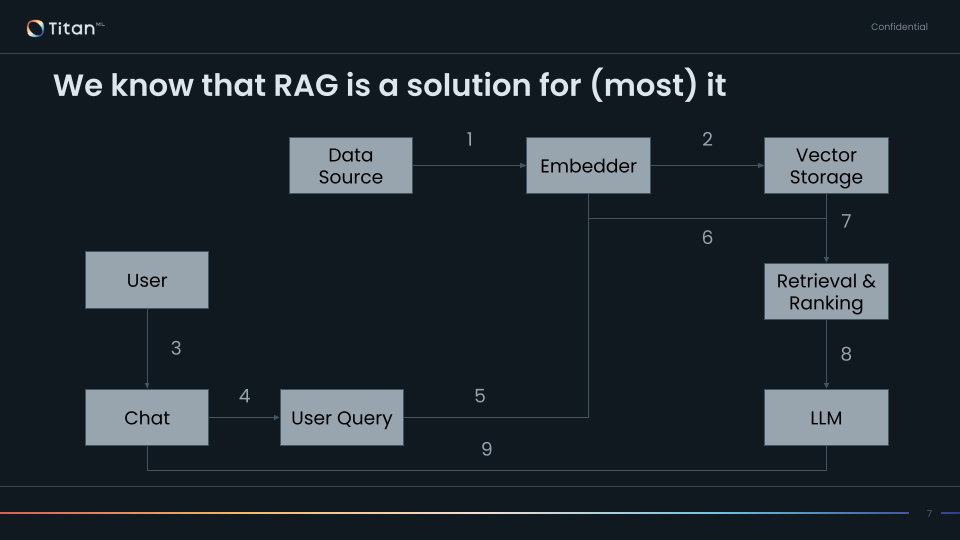

In [ ]:
!pip install pinecone-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.9/215.9 kB 1.0 MB/s eta 0:00:00


In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 853.8 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-ma

In [ ]:
from sentence_transformers import SentenceTransformer

class Embedding:
    def __init__(self, model_name: str, device: str = 'cpu', use_local: bool = False):
        self.model_name = model_name
        self.device = device
        self.use_local = use_local
        # Mapping of model names to their expected dimensions
        self.model_dimensions = {
            'all-MiniLM-L6-v2': 384,  # Example dimension for a SentenceTransformer model
            'jina-v2-base-en-embed': 768,  # Specified dimension for your local model
            # Add other models and their dimensions here
        }
        self.current_model_dimension = self.model_dimensions.get(model_name, None)

        if use_local:
            raise ValueError(f"Not yet implemented")
        else:
            self.model = SentenceTransformer(model_name, device=device)

    def switch_model(self, model_name: str, device: str):
        # Here we assume the model switch is successful and just set the dimension
        if model_name in self.model_dimensions:
            self.current_model_dimension = self.model_dimensions[model_name]
            print(f"Switched to model '{model_name}' with dimension {self.current_model_dimension}")
        else:
            print(f"Model '{model_name}' not recognized. Unable to switch models.")

    def embed(self, text: str) -> List[float]:
        if self.use_local:
          raise ValueError(f"Not yet implemented!")
        else:
            result = self.model.encode(text).tolist()
            if len(result) != self.current_model_dimension:
                print(f"Dimension mismatch detected: Expected {self.current_model_dimension}, got {len(result)}")
            return result

In [ ]:
import pinecone
from pinecone import Pinecone, ServerlessSpec

class PineconeVectorStorage(VectorStorage):
    def __init__(self, index_name: str, embedding: Embedding):
        super().__init__()
        PINECONE_API_KEY = os.environ.get("PINECONE_API_KEY")
        self.pinecone = Pinecone(api_key=PINECONE_API_KEY)
        self.index_name = index_name

        # Get the embedding dimension
        sample_text = "This is a sample text."
        sample_embedding = embedding.embed(sample_text)
        dimension = len(sample_embedding)

        if self.index_name in self.pinecone.list_indexes().names():
            # Check if the dimension of the existing index matches the embedding dimension
            index_info = self.pinecone.describe_index(self.index_name)
            if index_info.dimension != dimension:
                # Delete the existing index
                self.pinecone.delete_index(self.index_name)
                print(f"Deleted existing index '{self.index_name}' with mismatched dimension")
            else:
                print(f"Using existing index '{self.index_name}' with matching dimension")

        if self.index_name not in self.pinecone.list_indexes().names():
            # Create a new index with the correct dimension
            self.pinecone.create_index(
                name=self.index_name,
                dimension=dimension,
                metric='cosine',
                spec=ServerlessSpec(cloud='aws', region='us-west-2')
            )
            print(f"Created new index '{self.index_name}' with dimension {dimension}")

        self.index = self.pinecone.Index(self.index_name)

    def store_vectors(self, vectors: List[List[float]], metadatas: List[dict]):
        ids = [str(i) for i in range(len(vectors))]
        records = zip(ids, vectors, metadatas)
        self.index.upsert(vectors=records)

    def search_vectors(self, query_vector: List[float], top_n: int) -> List[dict]:
        results = self.index.query(top_k=top_n, vector=query_vector, include_metadata=True, include_values=False)
        return results['matches']

-0.226555318, -0.240306184, 0.052985698, 0.632352948, -0.728673577, 0.15122357, 0.331191123, -0.641429245, 0.428797096, 0.95760572, -0.494334489, -0.354309082, -0.538057208, 0.550637662, -0.258071, 1.19588697, 0.155630678, -0.0765811726, -0.243469238, -0.365808815, -0.0306158625, 0.407743573, -0.693355799, -0.0277745873, -0.0752204433, 0.625143588, 0.501838207, 0.0437227152, 0.268093348, 0.291489542, -0.708524823, -0.0817583874, -0.82088697, -0.126572549, -0.288037479, 0.0396082252, -0.0216818415, 0.388597369, 0.361742795, 0.555419922, -0.832524896, 0.939568043, 0.248133942, 0.185712025, -0.887235761, 0.169491038, -0.219231099, 0.337933719, 0.311717302, -0.413229555, -0.363101721, -0.632352948, -0.121102728, -0.623391569, -0.399090946, 0.535773754, 0.712919354, 0.162001669, -0.709156692, -0.496438414, -0.215231508, 1.10546875, -0.219284952, 0.504193485, 0.534696698, 0.0309484154, 0.0350090489, -0.859375, -0.0344072245, 0.299696982, 0.00521491561, 0.615866244, -0.0214628335, 0.130399823, 0.340676695, 0.656314611, 0.0678513497, -0.177317902, -0.965892136, 0.0423871204, 0.691750944, -0.216243967, 0.084099263, -0.409897745, -0.262009561, 0.0525620393, -0.656996787, 0.0209673718, 0.90119487, 0.0948342681, 0.18637085, 0.218376607, -0.085994944, 0.0365923718, 0.513614416, 0.572093308, 0.492130041, -0.744858682, -0.130917713, 0.0616087057, -0.283404171, 1.07562613, 0.185317099, -0.0903643444, -0.192928538, 0.191600129, 0.195398673, -0.935891569, 0.331158817, 0.245863974, -1.13924634, -0.503073275, 0.429917276, -0.936293662, 0.17014806, -0.291065902, 0.23110424, 0.591394782, -0.136402801, 0.296961159, -0.789292276, 0.797219694, 0.319899619, -0.290972531, 0.374048114, 0.388973475, 0.600930631, 0.628044605, 0.30426383, -0.871323526, 0.672234058, 0.00708725862, 0.586971521, -0.594410598, -1.34409463, 0.00410730718, 0.120734721, 0.382747889, -0.173224956, 0.673713207, -0.0961231887, 0.426556766, -0.716624558, -0.50432092, -0.432358682, -0.514716625, -0.142430916, 1.08111215, -0.228106335, -0.548770666, 1.02926815, -1.26578295, -0.271139711, 0.770163119, -0.122248031, -0.3149423, -0.00708007812, 0.142258584, 0.557961881, 0.465439737, -0.0545654297, -0.193667248, -0.484432459, -0.630773187, -0.12250115, 1.16567099, 0.600815713, -0.183837891, 0.107736923, -1.109375, 0.552246094, -0.232134655, -0.150146484, -0.487965316, 0.508300781, 0.389820784, 0.295683026, 0.634191155, -0.652717113, -0.835248172, 0.479492188, 0.924517453, 1.21179914, 0.833984375, -0.49442786, -0.091796875, 0.457548261, -0.560977697, 0.546203613, 0.296961159, -0.475435138, -0.484461159, 0.0699121803, -0.109461166, 0.284660786, -0.283296466, 0.737477, 0.142312437, -0.412563562, -0.119901769, -0.0388183594, 0.272906125, -0.457779825, -0.0827888, -0.341567099, -0.2159352, -1.29021144, -0.431698084, -0.389849484, -0.105382584, 0.288631678, 0.996783078, -0.623219192, 0.24769862, -0.505744457, 0.175652, 0.233628213, 0.228127867, -0.0942041725, 0.390610635, 0.24812457, -0.911994457, -0.331449628, -0.122239053, -0.358843625, 0.0910357311, 0.305635333, -0.0647978, -0.299517453, 0.601045489, 0.163287, 0.385555506, 0.788976312, -0.704733431, 0.179199219, -0.586454511, 0.843635082, -0.722541332, 0.349781722, 0.644588709, -0.489954323, 0.275705665, 0.130586505, -0.0805915371, -0.267538637, -0.388042271, 0.0716086, -0.236916929, -0.431220561, 0.151711851, 0.294329464, 0.459749103, 0.172523946, -0.398121566, 0.436178774, 0.130328014, -0.934283078, 0.182229429, 0.519933343, -0.271484375, 1.46587062, -1.09007359, 0.528837323, -0.110150509, 0.125183105, -0.378417969, 0.233319446, -0.0714237, -0.273385435, -0.189343616, 0.489703, -0.572782636, -0.0636201724, -0.735006869, -0.319910377, 0.41251868, -0.309670836, 0.397202432, 0.366803348, -0.0131692328, -0.42466107, -0.828354776, 0.141931877, -0.560173512, -0.779641569, 0.440662146, -0.0337632112, -0.476634294, 0.129046276, -0.441047221, 0.317411542, -0.161190256, 0.435690492, -0.513585687, 0.278147966, -0.519473791, 0.116232477, -0.0037164127, 0.13039346, 0.966624558, 0.0756674409, -0.86218977, -0.0997960716, 0.0131117878, 0.492302388, 0.441320091, -0.453871787, 0.571490109, -0.162087828, -0.701918662, 0.254998386, -0.455020666, -0.198360667, -0.55078125, 0.750229776, 0.0694292858, -0.593046308, 1.12775731, -0.406953692, 0.0216620956, 1.08554971, 0.216969207, 0.122529872, 0.704187751, 1.05859375, 0.19809857, -0.00904756412, -0.137551695, 0.479434729, -0.903636277, -0.509334803, -0.767980218, -0.568244457, -0.897058845, 0.317745447, 0.319986671, 0.340245873, -0.176596254, 0.341394752, -0.549991369, 0.597483933, 0.44609338, 0.199893728, 0.31316781, -0.778033078, -0.235811114, 0.0861134231, -0.0204934515, -1.04882812, 0.603285849, 0.868451297, 0.72374773, 0.212554932, 0.663308561, 0.904354334, -0.0571432672, -0.297672033, 0.980152786, -0.453756899, -1.03205419, -0.442038149, -0.349954039, -0.486385584, 0.343620747, 0.300617903, -0.795036793, 0.111328125, -0.305721521, -0.435747921, -0.0027070886, -0.811609626, 0.413890153, -0.183636829, 0.0155675551, -0.537310421, -0.415326297, 0.144656911, 0.531508505, -0.050809972, 0.215245858, -0.420424521, 1.12448299, 0.0693790242, 0.941578567, -0.514978766, 0.393151671, -0.0515495762, -0.759765625, 0.89177388, 0.659639239, -0.102646768, 0.272561461, 0.289245605, -0.100930609, -0.0689410046, 0.498319745, -0.29630056, -0.499174237, -1.15487134, 0.175282195, -0.0766094401, 0.011072495, 0.335208654, -0.3700023, -0.730053604, 0.880342364, 0.311595231, -0.54351449, 0.3958489, 0.44640395, -0.163265, -0.929457724, 0.035070084, 0.319479555, 0.277702779, -0.576286793, 0.210779533, -0.808134198, -0.312250912, -0.177174285, 0.0381146595, -0.795008063, -0.193287566, -0.376034021, -0.24931784, -0.112261601, -0.165642232, -0.158835024, 0.139641255, -0.439051, -0.716473758, 0.555305, 0.685891569, 0.144268259, 0.131469727, -0.611816406, -0.172262758, 0.462948084, 0.697667718, -1.13195086, -0.442871094, -0.225068927, -0.25865981, -0.658501148, -0.672334552, -0.0690487102, 0.249504536, 1.00465298, 1.03619027, 0.0871698707, 0.437643617, -0.345559508, 0.9296875, 0.116613053, -1.28285849, 0.744456589, -0.542049646, -0.236593813, 1.03056061, 0.500057459, -0.957261, -0.522145, -1.2959559, -0.749885082, 0.26887244, 0.670323968, -0.112003103, -0.157291189, 0.593793094, -0.210075825, 0.49972713, -0.848930836, -0.444393396, 0.619406283, 0.534352, 0.459645, -0.411678553, 0.0711239055, -0.0784983933, 0.649701297, 0.470071226, 0.14288111, -0.187912881, 0.490744203, -0.462861896, 0.217708811, 0.734719694, 0.953182459, -0.778952181, -0.330875158, 0.546487272, -0.250710875, -0.0397159345, 0.01911298, -0.0629021153, -0.328728169, -0.215533093, -0.133803427, 0.374493778, -0.422585875, 0.230899587, 0.109418087, -0.565889239, -0.316941202, -0.378317446, 0.14089787, 0.275364161, 0.21693331, 0.297327369, 0.686781943, -0.361414284, 0.361119896, 0.178150848, -0.807674646, 0.129480705, 0.704805255, 0.748391569, -0.3621898, 0.381433815, -0.13821052, -0.604262412, 0.784466922, 0.30329445, 1.06709564, -0.363640279, 0.210106343, 0.527473, 0.697035849, -0.45003733, 0.554170489, 0.458934098, -0.683306515, -0.277480185, -0.290355, -0.857306957, 0.418600649, -0.895450354, 0.770795047, -0.967572391, -0.262074202, -0.0772776902, 0.543238044, -0.291676253, 0.538847089, -0.751213551, 0.676413119, -0.896254599, -0.0798339844, 0.826746345, -0.345243573, 0.0742546543, -0.424775958, 0.0604176223, -0.873391569, 0.455394059, 0.408318, -0.673939407, -0.614028037, -0.660529613, -0.519990802, 0.932660282, -0.411793441, -0.749597907, 0.775534213, -0.637752771, 0.409208417, -0.143281817, -0.252193689, 0.15902172, 0.936695755, 0.306486249, -0.422621787, -0.203383505, -0.705307901, 0.189252064, 0.260139018, -1.34535849, 0.0774356648, 0.0950999558, -0.153000772, -0.484461159, 0.236830771, 0.577952683, 0.404742062, 0.610753655, 0.619140625, 0.633157194, 0.284294575, 1.00560093, -0.305042952, 0.479120582, 0.541503906, -0.070341222, 1.01286769, 0.903090537, -0.431453943, -0.446806073, 1.1553309, -0.129673675, 0.822323084, 0.565142453, -0.177084535, 0.155101106, -0.51786536, -0.191779643, 0.375157982, 0.551757812, -0.699448526, 0.223510742, -0.650419354, -0.420417339, 0.33033663, -0.589901209, 0.164938539, 0.152964875, 0.061634738, -1.00229776, 0.558378339, 0.775390625, -0.252857894, -0.13599351, 0.0382582732, 0.108608469, -0.283874512, -0.72771138, 0.882151902, 0.328530699, 0.461885333, -0.669354618, 0.254272461, 0.0534416661, -0.759248614, 0.510612965, -0.107249543, 0.221308991, 0.0116828466, -0.604549646, -0.228860289, 0.0592400059, -0.361215919, -0.405905336, 0.290563256, 0.239760458, 0.482371598, 0.123416677, 0.01869471, -0.264562279, 0.171903729, 0.433478862, -0.978515625, -1.10340071, -0.392922789, 0.284176111, -0.700137854, -1.07465672, 0.758272052, 0.845703125, 0.83984375, 0.325030148, 0.43936336, -0.0982540324, 0.00348977488, -0.468207866, 1.03573072, -0.240334898, -0.0319752395, -0.151726216, -1.26378679, -0.0694472343, 1.00028718, -0.260961205, 0.88166362, 0.588737965, 0.818416834, 0.179946, 0.755744457, 0.5703125, -0.331227034, 0.0548041835, -0.166613415, 0.525817871, -0.516296387, -0.141027108, 0.181927845, -0.0622774027, -0.167336851, -1.39970124, -0.620149493, -0.589829385, -1.32984829, -0.285946131, -0.0320039652, 0.940372229, 0.613388956, -1.03377759, -0.0282520968, 0.2681095, -0.12291044, -0.439453125, -0.35604319, 0.205638215, 0.51062727, -0.362986833, -0.329159021, 1.15050554, -0.0742331147, -0.461914062, -0.390280336, -0.36497587, 0.317899823, 0.632331371, -0.0161707252, -0.342654943, -1.16452205, -0.193897918, 0.281558752, -0.478573084, -0.0426815264, 0.568862, 0.316083133, 0.471552223, 0.183708638, 0.519962072, -0.558191657, 0.353644878, -0.319651872, 0.215001717, 0.60041362, 0.597943485, -0.375904769, -1.0147059, 0.838120401, -0.0931043, -0.797104776, -0.362204164, -0.0600657761, -1.33858, 0.173081338, 1.2934283, -0.0518116653, -0.121086568, -0.0917609707, -0.10728544, -0.374511719, -0.723704636, 0.878044605, 1.02493107, -0.127750173, -0.402659684, -0.139964387, -0.0904469192, -0.0794605911, -0.759133756, -0.624655306, 0.485380292, 0.00766170723, 0.133322328, 0.571174145, -0.517635584, 0.252197266, 0.452780336, 0.0905295, -0.11497587, 0.10915599, -0.301542401, -0.169921875, -0.210316375, -0.776884198

In [ ]:
class DataSource:
    def __init__(self, data: List[str]):
        self.data = data

    def preprocess_text(self, text: str) -> str:
      """
      Preprocesses the text by lowercasing, removing punctuation, and removing extra whitespace.

      Args:
          text (str): The input text to be preprocessed.

      Returns:
          str: The preprocessed text.
      """
      text = text.lower()
      text = text.translate(str.maketrans("", "", string.punctuation))
      text = re.sub(r"\s+", " ", text).strip()
      return text

    def preprocess_text_advanced(self, text: str) -> str:
        # Convert the text to lowercase
        text = text.lower()

        # Remove punctuation and numeric characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Tokenize the text
        tokens = nltk.word_tokenize(text)

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

        # Lemmatize the words
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        # Join the tokens back into a string
        text = ' '.join(tokens)

        return text

    def tokenize(self, text: str) -> str:
      """
      Tokenizes the preprocessed text into a list of words.

      Args:
          text (str): The preprocessed text to be tokenized.

      Returns:
          List[str]: A list of tokens (words) from the text.
      """
      return self.preprocess_text_advanced(text).split()

    def process_data(self) -> List[str]:
      self.processed_data = [self.preprocess_text_advanced(sentence) for sentence in self.data]
      return self.processed_data

In [ ]:
class RetrievalAndRanking:
    def __init__(self, data_source: DataSource, embedding: Embedding, vector_storage: VectorStorage):
        self.data_source = data_source
        self.embedding = embedding
        self.vector_storage = vector_storage

    def retrieve_relevant_chunks(self, query: str, top_n: int = 2) -> List[str]:
      """
      Retrieves the most relevant chunks from the data source based on the query.

      Args:
          query (str): The user's query.
          top_n (int): The number of top relevant chunks to retrieve (default is 2).

      Returns:
          List[str]: The list of top relevant chunks from the data source.
      """

      query_tokens = set(self.data_source.tokenize(query))
      similarities: List[Tuple[str, float]] = []

      for chunk in self.data_source.processed_data:
          chunk_tokens = set(self.data_source.tokenize(chunk))
          similarity = len(query_tokens.intersection(chunk_tokens)) / len(
              query_tokens.union(chunk_tokens)
          )
          similarities.append((chunk, similarity))

      similarities.sort(key=lambda x: x[1], reverse=True)
      return [chunk for chunk, _ in similarities[:top_n]]

    def retrieve_relevant_chunks_euclidean(self, query: str, top_n: int = 2) -> List[str]:
      # Create a TF-IDF vectorizer
      vectorizer = TfidfVectorizer()

      # Tokenize each string in the data source and join the tokens back into strings
      tokenized_data_source = [' '.join(self.data_source.tokenize(text)) for text in self.data_source.processed_data]

      # Fit and transform the tokenized data source
      tfidf_matrix = vectorizer.fit_transform(tokenized_data_source)

      # Tokenize the query and join the tokens back into a string
      tokenized_query = ' '.join(self.data_source.tokenize(query))

      # Transform the tokenized query
      query_vector = vectorizer.transform([tokenized_query])

      # Calculate the euclidean distance between the query and each chunk
      similarities = euclidean_distances(query_vector, tfidf_matrix).flatten()

      # Get the indices of the top-n closest chunks
      top_indices = similarities.argsort()[:top_n]

      # Return the top-n closest chunks
      return [self.data_source.processed_data[i] for i in top_indices]

    def retrieve_relevant_chunks_pinecone(self, query: str, top_n: int = 2) -> List[str]:
      query_vector = self.embedding.embed(query)
      results = self.vector_storage.search_vectors(query_vector, top_n)
      return [result['metadata']['text'] for result in results]

In [ ]:
def process_query(query: str, data_source: DataSource, retrieval_and_ranking: RetrievalAndRanking, llm: LLM, retrieval_method: str = "default") -> str:
    user_query = UserQuery(query)

    if retrieval_method == "default":
        relevant_chunks = retrieval_and_ranking.retrieve_relevant_chunks(user_query.query)
        context = "\n".join(relevant_chunks)
        answer = llm.answer_query(user_query.query, context)
    elif retrieval_method == "euclidean":
        relevant_chunks = retrieval_and_ranking.retrieve_relevant_chunks_euclidean(user_query.query)
        context = "\n".join(relevant_chunks)
        answer = llm.answer_query(user_query.query, context)
    elif retrieval_method == "pinecone":
        relevant_chunks = retrieval_and_ranking.retrieve_relevant_chunks_pinecone(user_query.query)
        answer = "\n".join(relevant_chunks)
    else:
        raise ValueError(f"Unknown retrieval method: {retrieval_method}")

    return answer

In [ ]:
def main(data_source:DataSource,
         retrieval_method: str = "default",
         model_choice: str = "openai",
         model_name: str = None,
         device: str = "cpu",
         embedding_model_name = 'all-MiniLM-L6-v2',
         use_local=False,
         index_name="my-index"
         ):
    embedding = Embedding(model_name=embedding_model_name,
                          device=device,
                          use_local=use_local)
    vector_storage = PineconeVectorStorage(index_name, embedding)
    processed_data = data_source.process_data()
    metadatas = [{'text': text} for text in processed_data]
    vectors = [embedding.embed(text) for text in processed_data]
    vector_storage.store_vectors(vectors, metadatas)
    retrieval_and_ranking = RetrievalAndRanking(data_source, embedding, vector_storage)

    if model_choice == "openai":
        llm = LLM(api_key=os.environ.get("OPENAI_API_KEY"))
    else:
        raise ValueError(f"Not yet implemented")

    while True:
        user_input = input("Enter your query (or type 'exit' to quit): ")
        if user_input.lower() == 'exit':
            break

        if retrieval_method == "default":
          answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        elif retrieval_method == "euclidean":
          answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        elif retrieval_method == "pinecone":
            answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        else:
            raise ValueError(f"Unknown retrieval method: {retrieval_method}")

        print(f"User Query: {user_input}")
        print(f"Answer: {answer}\n")

In [ ]:
data_source = DataSource(data)
data_source.process_data()
main(data_source,
     retrieval_method='pinecone',
     index_name="my-index-itam",
     embedding_model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Using existing index 'my-index-itam' with matching dimension
Enter your query (or type 'exit' to quit): exit


## Exercise 3: Filtering by Metadata

- Extend the `retrieve_relevant_chunks_pinecone` method in the `RetrievalAndRanking` class to allow filtering the results based on metadata.
- Add a new parameter `filter_metadata` to the method, which should be a dictionary representing the metadata filters.
- Modify the `search_vectors` method call in the `PineconeVectorStorage` class to include the `filter_metadata` parameter.
- Test the functionality by adding metadata to the chunks and using the `filter_metadata` parameter in the `retrieve_relevant_chunks_pinecone` method.
- Don't forget to update the `process_query` and `main` functions

In [ ]:
from typing import List, Dict, Optional

class RetrievalAndRanking:
    def __init__(self, data_source: DataSource, embedding: Embedding, vector_storage: VectorStorage):
        self.data_source = data_source
        self.embedding = embedding
        self.vector_storage = vector_storage

    def retrieve_relevant_chunks_pinecone(self, query: str, top_n: int = 2, filter_metadata: Optional[Dict] = None) -> List[str]:
      """
      Retrieves the most relevant chunks from the data source based on the query.

      Args:
          query (str): The user's query.
          top_n (int): The number of top relevant chunks to retrieve (default is 2).

      Returns:
          List[str]: The list of top relevant chunks from the data source.
      """

      query_tokens = set(self.data_source.tokenize(query))
      similarities: List[Tuple[str, float]] = []

      for chunk in self.data_source.processed_data:
          chunk_tokens = set(self.data_source.tokenize(chunk))
          similarity = len(query_tokens.intersection(chunk_tokens)) / len(
              query_tokens.union(chunk_tokens)
          )
          similarities.append((chunk, similarity))

      similarities.sort(key=lambda x: x[1], reverse=True)
      return [chunk for chunk, _ in similarities[:top_n]]

    def retrieve_relevant_chunks_euclidean(self, query: str, top_n: int = 2) -> List[str]:
      # Create a TF-IDF vectorizer
      vectorizer = TfidfVectorizer()

      # Tokenize each string in the data source and join the tokens back into strings
      tokenized_data_source = [' '.join(self.data_source.tokenize(text)) for text in self.data_source.processed_data]

      # Fit and transform the tokenized data source
      tfidf_matrix = vectorizer.fit_transform(tokenized_data_source)

      # Tokenize the query and join the tokens back into a string
      tokenized_query = ' '.join(self.data_source.tokenize(query))

      # Transform the tokenized query
      query_vector = vectorizer.transform([tokenized_query])

      # Calculate the euclidean distance between the query and each chunk
      similarities = euclidean_distances(query_vector, tfidf_matrix).flatten()

      # Get the indices of the top-n closest chunks
      top_indices = similarities.argsort()[:top_n]

      # Return the top-n closest chunks
      return [self.data_source.processed_data[i] for i in top_indices]

    def retrieve_relevant_chunks_pinecone(self, query: str, top_n: int = 2) -> List[str]:
      # UPDATE HERE
      # Realiza la búsqueda en Pinecone incluyendo los metadatos y filtrando según filter_metadata

      query_vector = self.embedding.embed(query)
      results = self.vector_storage.search_vectors(query_vector, top_n, filter_metadata=filter_metadata)
      return [result['metadata']['text'] for result in results]

In [ ]:
class PineconeVectorStorage(VectorStorage):
    def __init__(self, index_name: str, embedding: Embedding):
        super().__init__()
        PINECONE_API_KEY = os.environ.get("PINECONE_API_KEY")
        self.pinecone = Pinecone(api_key=PINECONE_API_KEY)
        if index_name not in self.pinecone.list_indexes().names():
            self.pinecone.create_index(
                name=index_name,
                dimension=embedding.model.get_sentence_embedding_dimension(),
                metric='cosine',
                spec=ServerlessSpec(cloud='aws', region='us-west-2')
            )
        self.index = self.pinecone.Index(index_name)

    def store_vectors(self, vectors: List[List[float]], metadatas: List[dict]):
        ids = [str(i) for i in range(len(vectors))]
        records = zip(ids, vectors, metadatas)
        self.index.upsert(vectors=records)

    def search_vectors(self, query_vector: List[float], top_n: int, filter_metadata: dict = None) -> List[dict]:
        if filter_metadata is None:
            filter_metadata = {}  #  filter_metadata es un diccionario vacío si no se proporciona

        # Realiza la consulta a Pinecone incluyendo los metadatos y aplicando el filtrado
        results = self.index.query(top_k=top_n, vector=query_vector, include_metadata=True, include_values=False, filter=filter_metadata)

        return results['matches']

In [ ]:
def main(data_source:DataSource,
         retrieval_method: str = "default",
         model_choice: str = "openai",
         model_name: str = None,
         device: str = "cpu",
         embedding_model_name = 'all-MiniLM-L6-v2',
         use_local=False,
         index_name="my-index"
         ):
    embedding = Embedding(model_name=embedding_model_name,
                          device=device,
                          use_local=use_local)
    vector_storage = PineconeVectorStorage(index_name, embedding)
    processed_data = data_source.process_data()
    # Update here for metadata
    metadatas = [{'text': text} for text in processed_data]
    vectors = [embedding.embed(text) for text in processed_data]
    vector_storage.store_vectors(vectors, metadatas)
    retrieval_and_ranking = RetrievalAndRanking(data_source, embedding, vector_storage)

    if model_choice == "openai":
        llm = LLM(api_key=os.environ.get("OPENAI_API_KEY"))
    else:
        raise ValueError(f"Not yet implemented")

    while True:
        user_input = input("Enter your query (or type 'exit' to quit): ")
        if user_input.lower() == 'exit':
            break

        if retrieval_method == "default":
          answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        elif retrieval_method == "euclidean":
          answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        elif retrieval_method == "pinecone":
            answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        else:
            raise ValueError(f"Unknown retrieval method: {retrieval_method}")

        print(f"User Query: {user_input}")
        print(f"Answer: {answer}\n")

### Let's update!


Possible queries:
- "What is the purpose of carbon trading?"
- "How do ESG criteria evaluate a company's environmental impact?"
- "What is the recipe for making a perfect pizza?"

In [ ]:
data_source = DataSource(data)
data_source.process_data()
main(data_source, retrieval_method='pinecone', index_name="my-index4", embedding_model_name="all-MiniLM-L6-v2")

Enter your query (or type 'exit' to quit): How do ESG criteria evaluate a company's environmental impact?
User Query: How do ESG criteria evaluate a company's environmental impact?
Answer: esg factor consider company environmental impact carbon footprint waste management use renewable energy
carbon trading esg closely related company lower carbon emission better sustainability practice tend higher esg rating

Enter your query (or type 'exit' to quit): exit


## Exercise 4: Semantic Search with Multiple Queries

- Modify the `retrieve_relevant_chunks_pinecone` method in the `RetrievalAndRanking` class to accept a list of queries instead of a single query.
- Embed each query using the Sentence Transformers model and calculate the average embedding (hint use `numpy mean`).
- Use the average embedding to search for relevant chunks in Pinecone.
- Update the `process_query` and `main` function to handle multiple queries.

In [ ]:
import numpy as np

In [ ]:
class RetrievalAndRanking:
    def __init__(self, data_source: DataSource, embedding: Embedding, vector_storage: VectorStorage):
        self.data_source = data_source
        self.embedding = embedding
        self.vector_storage = vector_storage

    def retrieve_relevant_chunks(self, query: str, top_n: int = 2) -> List[str]:
      """
      Retrieves the most relevant chunks from the data source based on the query.

      Args:
          query (str): The user's query.
          top_n (int): The number of top relevant chunks to retrieve (default is 2).

      Returns:
          List[str]: The list of top relevant chunks from the data source.
      """

      query_tokens = set(self.data_source.tokenize(query))
      similarities: List[Tuple[str, float]] = []

      for chunk in self.data_source.processed_data:
          chunk_tokens = set(self.data_source.tokenize(chunk))
          similarity = len(query_tokens.intersection(chunk_tokens)) / len(
              query_tokens.union(chunk_tokens)
          )
          similarities.append((chunk, similarity))

      similarities.sort(key=lambda x: x[1], reverse=True)
      return [chunk for chunk, _ in similarities[:top_n]]

    def retrieve_relevant_chunks_euclidean(self, query: str, top_n: int = 2) -> List[str]:
      # Create a TF-IDF vectorizer
      vectorizer = TfidfVectorizer()

      # Tokenize each string in the data source and join the tokens back into strings
      tokenized_data_source = [' '.join(self.data_source.tokenize(text)) for text in self.data_source.processed_data]

      # Fit and transform the tokenized data source
      tfidf_matrix = vectorizer.fit_transform(tokenized_data_source)

      # Tokenize the query and join the tokens back into a string
      tokenized_query = ' '.join(self.data_source.tokenize(query))

      # Transform the tokenized query
      query_vector = vectorizer.transform([tokenized_query])

      # Calculate the euclidean distance between the query and each chunk
      similarities = euclidean_distances(query_vector, tfidf_matrix).flatten()

      # Get the indices of the top-n closest chunks
      top_indices = similarities.argsort()[:top_n]

      # Return the top-n closest chunks
      return [self.data_source.processed_data[i] for i in top_indices]

    def retrieve_relevant_chunks_pinecone(self, queries: List[str], top_n: int = 2, filter_metadata: dict = None) -> List[str]:
      # Embed each query using Sentence Transformers
      query_embeddings = [self.embedding.embed(query) for query in queries]

      # Calculate the average embedding
      average_embedding = np.mean(query_embeddings, axis=0)

      # Convert the average embedding from an ndarray to a list
      average_embedding = average_embedding.tolist()  # Importante para la serialización

      # Search for relevant chunks in Pinecone using the average embedding
      results = self.vector_storage.search_vectors(average_embedding, top_n, filter_metadata=filter_metadata)

      return [result['metadata']['text'] for result in results]



In [ ]:
def process_query(queries: List[str], data_source: DataSource, retrieval_and_ranking: RetrievalAndRanking, llm: LLM, retrieval_method: str = "default") -> str:
    # Para manejar todas las consultas a la vez con Pinecone
    if retrieval_method == "pinecone":
        relevant_chunks = retrieval_and_ranking.retrieve_relevant_chunks_pinecone(queries, filter_metadata={'category': 'finance'})
        answers = "\n".join(relevant_chunks)
        return answers

    # Loop through each query for other methods
    answers = []
    for query in queries:
        user_query = UserQuery(query)

        if retrieval_method == "default":
            relevant_chunks = retrieval_and_ranking.retrieve_relevant_chunks(user_query.query)
            context = "\n".join(relevant_chunks)
        elif retrieval_method == "euclidean":
            relevant_chunks = retrieval_and_ranking.retrieve_relevant_chunks_euclidean(user_query.query)
            context = "\n".join(relevant_chunks)
        else:
            raise ValueError(f"Unknown retrieval method: {retrieval_method}")

        answer = llm.answer_query(user_query.query, context)
        answers.append(answer)

    return "\n".join(answers)


In [ ]:
def main(data_source:DataSource,
         retrieval_method: str = "default",
         model_choice: str = "openai",
         model_name: str = None,
         device: str = "cpu",
         embedding_model_name = 'all-MiniLM-L6-v2',
         use_local=False,
         index_name="my-index"
         ):
    embedding = Embedding(model_name=embedding_model_name,
                          device=device,
                          use_local=use_local)
    vector_storage = PineconeVectorStorage(index_name, embedding)
    processed_data = data_source.process_data()
    # Update here for metadata
    metadatas = [{'text': text, 'category': 'finance'} for text in processed_data]
    vectors = [embedding.embed(text) for text in processed_data]
    vector_storage.store_vectors(vectors, metadatas)


    retrieval_and_ranking = RetrievalAndRanking(data_source, embedding, vector_storage)

    if model_choice == "openai":
        llm = LLM(api_key=os.environ.get("OPENAI_API_KEY"))
    else:
        raise ValueError(f"Not yet implemented")

    while True:
        user_input = input("Enter your queries separated by commas (or type 'exit' to quit): ")
        if user_input.lower() == 'exit':
            break

        queries = [query.strip() for query in user_input.split(',')]

        # Update here
        answer = process_query(queries, data_source, retrieval_and_ranking, llm, retrieval_method)

        print("User Queries:")
        for query in queries:
            print(query)
        print("Answer:")
        print(answer)
        #print(f"User Query: {user_input}")
        #print(f"Answer: {answer}\n")

In [ ]:
data_source = DataSource(data)
data_source.process_data()
main(data_source, retrieval_method='pinecone', index_name="my-index4", embedding_model_name="all-MiniLM-L6-v2")

Enter your queries separated by commas (or type 'exit' to quit): What is the purpose of carbon trading?
User Queries:
What is the purpose of carbon trading?
Answer:
goal carbon trading encourage company invest cleaner technology adopt sustainable practice reduce emission avoid cost purchasing additional carbon credit
carbon trading marketbased approach reducing greenhouse gas emission providing economic incentive company limit carbon footprint
Enter your queries separated by commas (or type 'exit' to quit): exit
